In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.metrics import recall_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [2]:
# open the pre-processed csv file and split the target variable from the classifiers
df = pd.read_csv('dota2_cleaned.csv')

# Shuffle the dataframe before the train test split  
df = df.sample(frac=1).reset_index(drop=True)

#separate the target variable
labels = df[['Won']]
df.drop(['Won'], axis=1, inplace=True)

In [3]:
def print_metrics(labels, predictions, print_score=None):
    ''' This function receives model predictions along with the actual labels
        and returns the precision score, recall, accuracy and F1'''
    
    recall = round(recall_score(labels, predictions)*100, 2)
    acc = round(accuracy_score(labels, predictions)*100, 2)
    
    if print_score:
        print(f"Recall Score: {recall}")
        print(f"Accuracy Score: {acc}")
        
    return recall, acc

In [4]:
def plot_confusion_matrix(y_test, y_predict, classes=None, title=None):
    cm = confusion_matrix(y_test, y_predict)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

 #####   
import itertools

def plot_confusion_matrix2(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [5]:
# create seprate training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.25)

#   KNN Model:

In [6]:
from sklearn.neighbors import KNeighborsClassifier

# run initial model with default value (k=5)
knn = KNeighborsClassifier()
knn.fit(x_train, y_train.values.ravel())

test_predict = knn.predict(x_test)

recall, acc = print_metrics(y_test, test_predict, print_score=True)

Recall Score: 51.97
Accuracy Score: 50.84


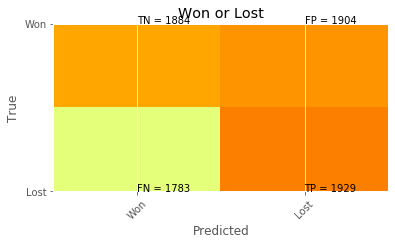

In [7]:
plot_confusion_matrix(y_test, test_predict, classes=['Won', 'Lost'], title='Won or Lost')

In [ ]:
# find the most important features

## Initial KNN model performed slightly better than random guess 
Recall Score: 53.25%

Accuracy Score: 51.72%

In [ ]:
def multiple_knn(df, labels, ks=[5]):
    x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.3)
    best_acc = 0
    best_k = 0
    scores = []

    for k in tqdm(ks):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train.values.ravel())
        test_predict = knn.predict(x_test)
        score = print_metrics(y_test, test_predict)
        scores.append(score)
        
        if best_acc < score[1]:
            best_acc = score[1]
            best_k = k
            
        
    return best_acc, best_k, scores

In [ ]:
# run model again k = 4, 6, 7, 8, 9
acc, k, scores = multiple_knn(df, labels, ks=[4, 6, 7, 8, 9])
print(f"scores: {scores}, k: {k}")

In [ ]:
# run model again k = 8, 9, 10, 11, 12
acc, k, scores = multiple_knn(df, labels, ks=[8, 9, 10, 11, 12, 14])
print(f"scores: {scores}, k: {k}")

## KNN = 11


Recall - 54.33% 

Accuracy = 52.39%


In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(x_train, y_train.values.ravel())

k11_predict = knn.predict(x_test)

In [ ]:
cm1 = confusion_matrix(y_test, k11_predict)

In [ ]:
plot_confusion_matrix2(cm=cm1, normalize = False,
                       target_names = ['Win', 'Lose'],
                       title = "Confusion Matrix")

# Decision Trees

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
# get a baseline how random forest performs
forest = RandomForestClassifier()
forest.fit(x_train, y_train)

# predcit accuracy
forest_test_pred = forest.predict(x_test)

# testing accuracy
f_recall, f_acc = print_metrics(y_test, forest_test_pred, print_score=True)
plot_confusion_matrix(y_test, forest_test_pred, classes=['Won', 'Lost'], title='Won or Lost')

### Random Forest Using Gridsearch

In [ ]:
# define params grid
forest_param_grid = {'criterion': ['gini', 'entropy'],
                     'max_depth': [3, 4, 6, 7],
                     'min_samples_split': [3, 5, 6, 7],
                     'min_samples_leaf': [3, 4, 5, 6]
                    }                    

In [ ]:
# Use grid search to find the best paramers for random forest
forest_search = GridSearchCV(forest, forest_param_grid, cv=3, verbose=1, scoring='accuracy')
forest_search.fit(x_train, y_train.values.ravel())

# predcit the testing data
forest_grid_test_pred = forest_search.predict(x_test)

# test how the model performs 
forest_grid_recall, forest_grid_acc = print_metrics(y_test, forest_grid_test_pred, print_score=True)
best_forest_params = forest_search.best_params_

#best paramters
print(f"Best paramaters: {best_forest_params}")

In [ ]:
plot_confusipon_matrix(y_test, forest_grid_test_pred, classes=['Won', 'Lost'], title='Won or Lost')

#### Optimal Parameters: {'criterion': 'gini','max_depth': 6,'min_samples_leaf': 5,'min_samples_split': 7}

Accuracy = 99.99%

# AdaBoost

In [ ]:
# get a baseline on how ada boost performs
adaboost = AdaBoostClassifier()
adaboost.fit(x_train, y_train.values.ravel())

# predict the  testing data
adaboost_test_pred = adaboost.predict(x_test)

# test how the model performs 
ada_recall, ada_accuracy = print_metrics(y_test, adaboost_test_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, adaboost_test_pred, classes=['Won', 'Lost'], title='Won or Lost')

### AdaBoost Using Gridsearch

In [ ]:
adaboost_param_grid = {'n_estimators': [70, 150, 200, 250, 270, 300],
                       'learning_rate': [0.4, 0.2, 0.1]
                      }

In [ ]:
ada_grid_search = GridSearchCV(adaboost, adaboost_param_grid, cv=3)
ada_grid_search.fit(x_train, y_train.values.ravel())

# predict the testing data
adagrid_pred = ada_grid_search.predict(x_test)

# test how well the model performs 
adagrid_recall, adagrid_accuracy = print_metrics(y_test, adagrid_pred, print_score=True)

#best paramters
best_ada_params = ada_grid_search.best_params_

In [ ]:
plot_confusion_matrix2(cm=confusion_matrix(y_test, adagrid_pred), classes=['Won', 'Lost'], title='Won or Lost')

#### Optimal Parameters: {'learning_rate': 0.6, 'n_estimators': 270}
Score = 57%

# XGBoost

In [ ]:
import xgboost as xgb

# check baseline accuracy for xgboost
xgbooster = xgb.XGBClassifier()
xgbooster.fit(x_train, y_train.values.ravel())

# predict the testing data
xgb_pred = xgbooster.predict(x_test)

# test how well the model performs 
xgb_recall, xgb_accuracy = print_metrics(y_test, xgb_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, xgb_pred, classes=['Won', 'Lost'], title='Won or Lost')

In [ ]:
xgbooster.feature_importances_

### XGBoost Using Gridsearch

In [ ]:
xg_param_grid = {'learning_rate': [0.2], 'max_depth': [7], 
                 'min_child_weight': [5, 6], 'subsample': [0.7],
                 'n_estimators': [100, 120, 150]
                }

In [ ]:
xg_grid = GridSearchCV(xgbooster, xg_param_grid, scoring='accuracy', cv=3, n_jobs=1)
xg_grid.fit(x_train, y_train.values.ravel())

best_parameters = xg_grid.best_params_

training_preds = xg_grid.predict(x_train)
test_preds = xg_grid.predict(x_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(best_parameters)
print(training_accuracy)
print(test_accuracy)

In [ ]:
xg_grid.

In [ ]:
'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}
0.708952380952381
0.7056666666666667

In [ ]:
def feature_importance(model, x_train):
    importances = model.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
     
    if indices > 10:
        indices = indices[::10]
        features = x_train.shape[1]


In [ ]:
plt.figure(figsize=(20, 20))
plt.barh(range(x_train.shape[1]), xgbooster.feature_importances_, align='center')
plt.yticks(np.arange(x_train.shape[1]), x_train.columns.values)
plt.xlabel("Feature importance")
plt.ylabel("Feature")

In [ ]:
def plot_feature_importances(model):
   n_features = X_train.shape[1]
   plt.figure(figsize=(8,8))
   plt.barh(range(n_features), model.feature_importances_, align='center')
   plt.yticks(np.arange(n_features), X_train.columns.values)
   plt.xlabel("Feature importance")
   plt.ylabel("Feature")

In [ ]:
a = np.argsort(xgbooster.feature_importances_)[::-1]

In [ ]:
xgbooster.feature_importances_

In [ ]:
a[10::]